In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import utils as u
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import result_gen_utils as ru
from scipy.stats import norm

# results

1) The fabnet explanation in the bullet point, point 1 needs more explanation.

2) The fabnet smilarity matters because we might not have the same behavior. The VGG threshold should, however, have been introduced in a more principled way.. First show explanability of the faceswap. VGG similarity to my top-1 matters a lot. VGG simialrity has an issue of in-between similarity but not FAb-Net

3) say faceswap and not generic deep fakes

4) Have the T_v explanation of geodesic path explation should go in the authentication section.

5) VGG or FabNet only as baselines


In [2]:
def read_results(in_df_name, n=-1):
    
    in_df = pd.read_pickle(in_df_name)
    in_df = in_df.reset_index()
    if n>0:
        in_df = in_df.sample(n=n, replace=False, random_state=0)
    return in_df

# get the features with dataset

In [22]:

def get_features(in_df):

    # get idividual distances
    for k in in_df.keys():

        # assign behavior ids 
        in_df[k]['actualLabel_behav'] = ru.get_behav_id(in_df[k])
        in_df[k]['vgg_behav_id_sim'] = ru.get_vgg_behav_id(in_df[k])
        in_df[k]['vgg_face_id_sim'] = ru.get_vgg_face_id(in_df[k])
        in_df[k]['fab_face_id_sim'] = ru.get_fab_face_id(in_df[k])
        in_df[k]['fab_behav_id_sim'] = ru.get_fab_behav_id(in_df[k])
        in_df[k]['only_fab'] = ru.get_max_fab(in_df[k])
        in_df[k]['only_vgg'] = ru.get_max_vgg(in_df[k])
        # assign behavior ids 
        result_dfs[k]['scaleMaxVGG86_fab040'] = ru.get_comb_Or_scaleMaxVGGFab(result_dfs[k], 
                                                                       mu_sigVGG=(0.86, 0.0001), 
                                                                       mu_sigFab=(0.4, 0.0001))
        result_dfs[k]['scaleMaxVGG88_fab040'] = ru.get_comb_Or_scaleMaxVGGFab(result_dfs[k], 
                                                                       mu_sigVGG=(0.88, 0.0001), 
                                                                       mu_sigFab=(0.4, 0.0001))
        
        result_dfs[k]['scaleMaxVGG80_fab040'] = ru.get_comb_Or_scaleMaxVGGFab(result_dfs[k], 
                                                                       mu_sigVGG=(0.80, 0.0001), 
                                                                       mu_sigFab=(0.4, 0.0001))


# a plot with ids on the x axis, y axis is vgg/fabnet
def print_sim_acc(in_dict, keys, r_or_f, feat_nm, cur_thres=None):
    
    if cur_thres==None:
        cur_thres = ru.compute_threshold(in_dict, keys, feat_nm, n=1000, cutoff = 0.01)
        print(f': {cur_thres:0.2f}', end='')
    
    print('')
    print(r_or_f, end='|')
    for k in keys:
        cur_acc, cur_optout = ru.compute_accuracy(in_dict[k], feat_nm, cur_thres)
        if r_or_f == 'real':
            print(f'\t{cur_acc*100:0.1f} ({cur_optout:0.2f})', end=' ')
        else:
            print(f'\t{(1-cur_acc)*100:0.1f} ({cur_optout:0.2f})', end=' ')
                
    
    print('\n---------------------------------------------------------------------------------------------------')
    return cur_thres


def plot_distribution(in_dict, in_keys, in_feat_nms, in_leg, title, ax):
    
    bins = np.linspace(0, 1, 25)
    for i in range(len(in_keys)):
        
        cur_arr = np.array(in_dict[in_keys[i]][in_feat_nms[i]].dropna())
        if np.std(cur_arr) == 0:
            cur_arr = cur_arr + np.random.normal(loc=0, scale=0.01, size=cur_arr.shape)
        sns.distplot(cur_arr, 
                     bins=bins, label=in_leg[i], ax=ax)
        ax.set_xticks(bins)
        ax.set_xticklabels([f'{x:.2f}' for x in bins], rotation=90)
        ax.legend()
        ax.set_title(title)
        ax.set_xlim([0.0, 1.0])
        ax.grid(b=True)
        

# plot the distances
def plot_one_row(in_pref, in_suf):
    
    _, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
    real_key = in_pref + '_real_100' + in_suf
    fake_key = in_pref + '_fake_100' + in_suf
    
    plot_distribution(result_dfs, 
                      [real_key, fake_key, fake_key], 
                      ['vgg_face_id_sim', 'vgg_face_id_sim', 'vgg_behav_id_sim'], 
                      ['real_FId', 'fake_FId', 'fake_BId'], 'VGG from Face/Behav', ax=ax[0])
    plot_distribution(result_dfs, 
                      [real_key, fake_key, fake_key], 
                      ['fab_face_id_sim', 'fab_face_id_sim', 'fab_behav_id_sim'], 
                      ['real_FId', 'fake_FId', 'fake_BId'], 'Fab from Face/Behav', ax=ax[1])
    plt.suptitle(in_pref)
    plt.show()


# compression and rescale

		ldr		FF		GG		DFDC		SJ



1% Reject Max VGG 0.85 Fab 0.75 
real|	0.00 (0.00) 	0.00 (0.00) 	0.01 (0.00) 	0.05 (0.00) 	0.00 (0.00) 
---------------------------------------------------------------------------------------------------

fake|	1.00 (0.00) 	1.00 (0.00) 	1.00 (0.00) 	0.98 (0.00) 	1.00 (0.00) 
---------------------------------------------------------------------------------------------------


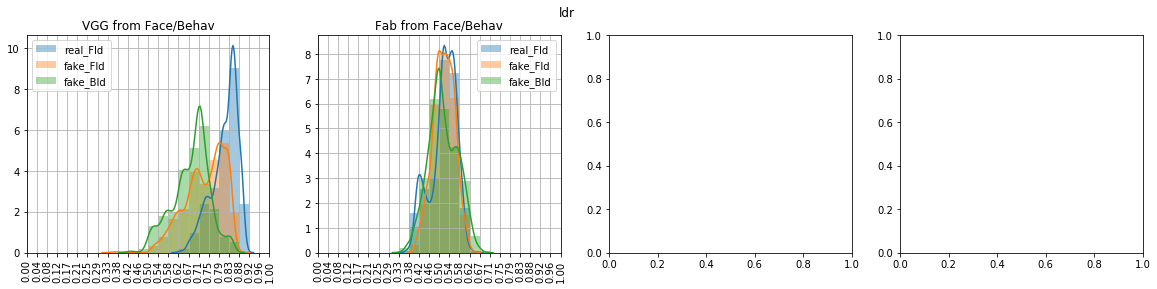

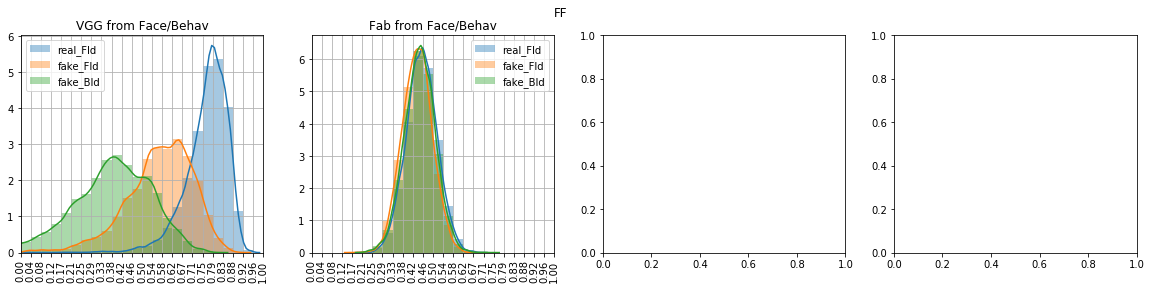

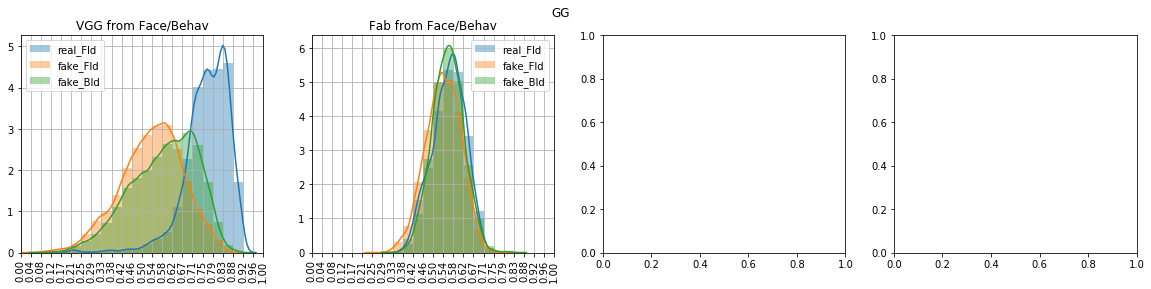

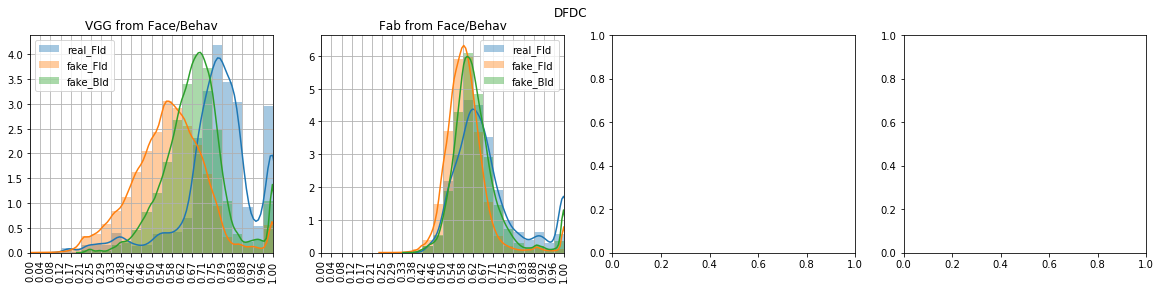

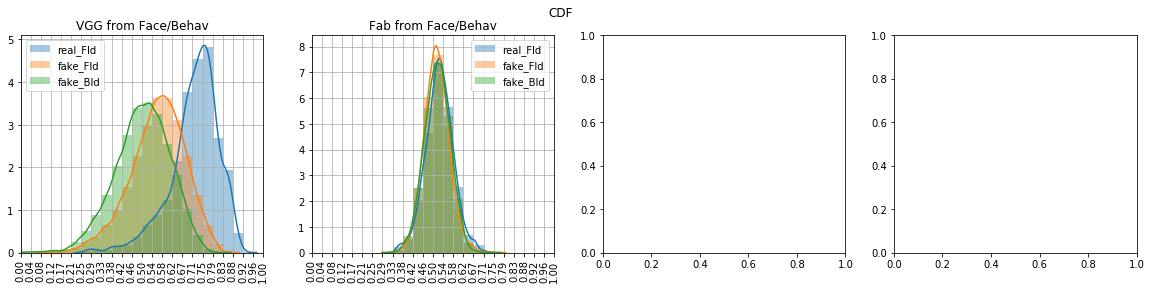

In [46]:
result_dfs = {}
result_dfs['ldr_real_100_comp'] = read_results('result_csv/ldr_real_100_comp.csv')
result_dfs['ldr_fake_100_comp'] = read_results('result_csv/ldr_fake_100_comp.csv')
result_dfs['FF_real_100_comp'] = read_results('result_csv/FF_real_100_comp.csv')
result_dfs['FF_fake_100_comp'] = read_results('result_csv/FF_fake_100_comp.csv')
result_dfs['GG_real_100_comp'] = read_results('result_csv/GG_real_100_comp.csv')
result_dfs['GG_fake_100_comp'] = read_results('result_csv/GG_fake_100_comp.csv')
result_dfs['DFDC_real_100_comp'] = read_results('result_csv/DFDC_real_100_comp.csv')
result_dfs['DFDC_fake_100_comp'] = read_results('result_csv/DFDC_fake_100_comp.csv')
result_dfs['CDF_real_100_comp'] = read_results('result_csv/CDF_real_100_comp.csv')
result_dfs['CDF_fake_100_comp'] = read_results('result_csv/CDF_fake_100_comp.csv')
get_features(result_dfs)

u.save_obj(result_dfs, 'cache', 'compression_rescale_accuracy')

def result_comp():
    
    print('\t\tldr\t\tFF\t\tGG\t\tDFDC\t\tSJ\n')
    print('\n')
    print('1% Reject Max VGG 0.85 Fab 0.75', end=' ')
    print_sim_acc(result_dfs, ['ldr_real_100_comp',
                               'FF_real_100_comp',
                               'GG_real_100_comp',
                               'DFDC_real_100_comp',
                               'CDF_real_100_comp'], 
                  'real', 'scaleMaxVGG85_fab040', cur_thres = 0.0001)
    print_sim_acc(result_dfs, ['ldr_fake_100_comp',
                               'FF_fake_100_comp',
                               'GG_fake_100_comp',
                               'DFDC_fake_100_comp',
                               'CDF_fake_100_comp'], 
                  'fake', 'scaleMaxVGG85_fab040', cur_thres = 0.0001)

result_comp()

plot_one_row('ldr', '_comp')
plot_one_row('FF', '_comp')
plot_one_row('GG', '_comp')
plot_one_row('DFDC', '_comp')
plot_one_row('CDF', '_comp')


# only compression

In [20]:
result_dfs = {}
result_dfs['ldr_real_100_comp'] = read_results('result_csv/ldr_real_100_onlycomp.csv')
result_dfs['ldr_fake_100_comp'] = read_results('result_csv/ldr_fake_100_onlycomp.csv')
result_dfs['DFDC_real_100_comp'] = read_results('result_csv/DFDC_real_100_onlycomp.csv')
result_dfs['DFDC_fake_100_comp'] = read_results('result_csv/DFDC_fake_100_onlycomp.csv')
result_dfs['FF_real_100_comp'] = read_results('result_csv/FF_real_100_onlycomp.csv')
result_dfs['FF_fake_100_comp'] = read_results('result_csv/FF_fake_100_onlycomp.csv')
result_dfs['GG_real_100_comp'] = read_results('result_csv/GG_real_100_onlycomp.csv')
result_dfs['GG_fake_100_comp'] = read_results('result_csv/GG_fake_100_onlycomp.csv')
result_dfs['CDF_real_100_comp'] = read_results('result_csv/CDF_real_100_onlycomp.csv')
result_dfs['CDF_fake_100_comp'] = read_results('result_csv/CDF_fake_100_onlycomp.csv')
get_features(result_dfs)

u.save_obj(result_dfs, 'cache', 'only_compression_accuracy')


		ldr		FF		GG		DFDC		CDF



Max VGG 0.86 
real|	95.9 (0.00) 	96.9 (0.00) 	92.1 (0.00) 	79.7 (0.00) 	87.3 (0.00) 
---------------------------------------------------------------------------------------------------

fake|	93.1 (0.00) 	99.2 (0.00) 	94.2 (0.00) 	82.1 (0.00) 	99.3 (0.00) 
---------------------------------------------------------------------------------------------------
Max VGG 0.88 
real|	93.7 (0.00) 	95.4 (0.00) 	91.2 (0.00) 	76.1 (0.00) 	81.5 (0.00) 
---------------------------------------------------------------------------------------------------

fake|	94.8 (0.00) 	99.5 (0.00) 	96.4 (0.00) 	89.1 (0.00) 	99.7 (0.00) 
---------------------------------------------------------------------------------------------------
Max VGG 0.80 
real|	99.2 (0.00) 	98.6 (0.00) 	92.5 (0.00) 	84.7 (0.00) 	96.3 (0.00) 
---------------------------------------------------------------------------------------------------

fake|	90.8 (0.00) 	98.4 (0.00) 	84.6 (0.00) 	59.5 (0.00) 	95.6 (0.00) 
-

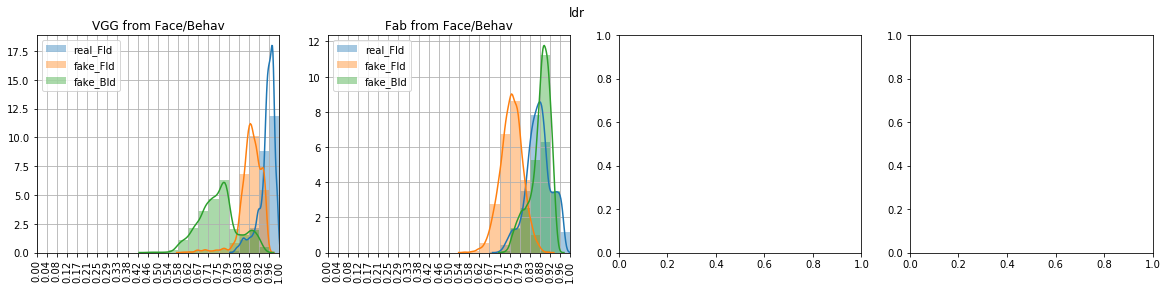

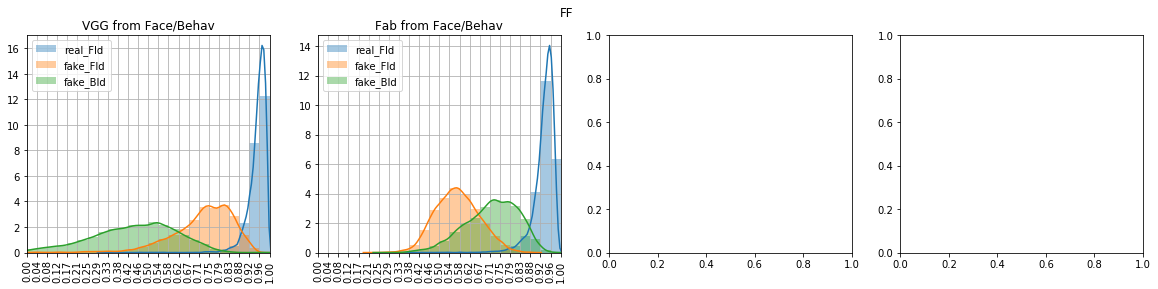

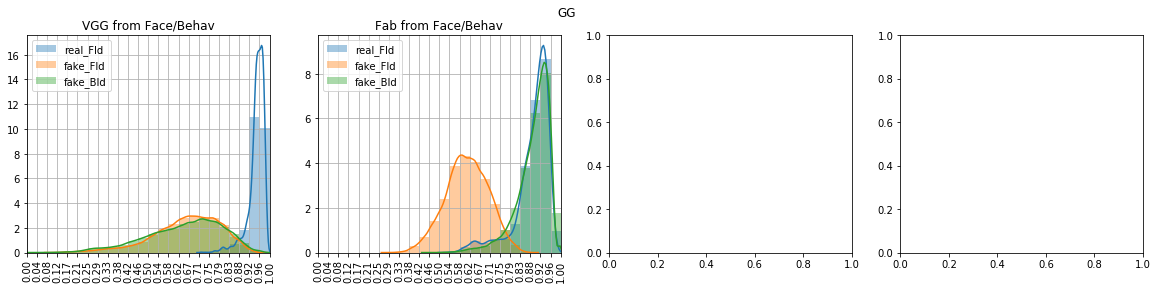

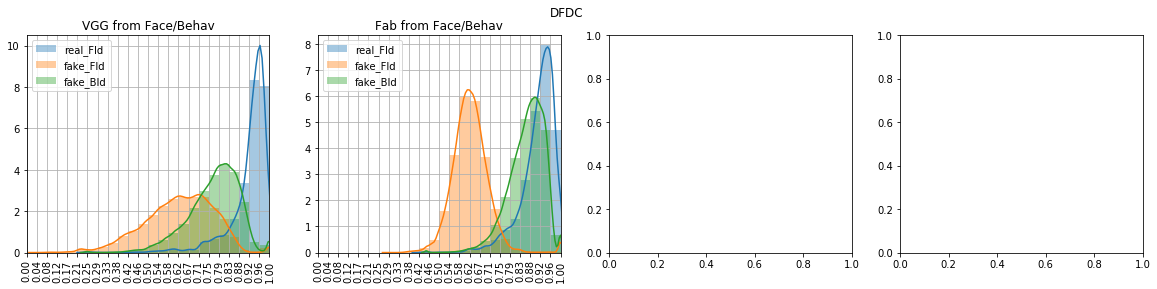

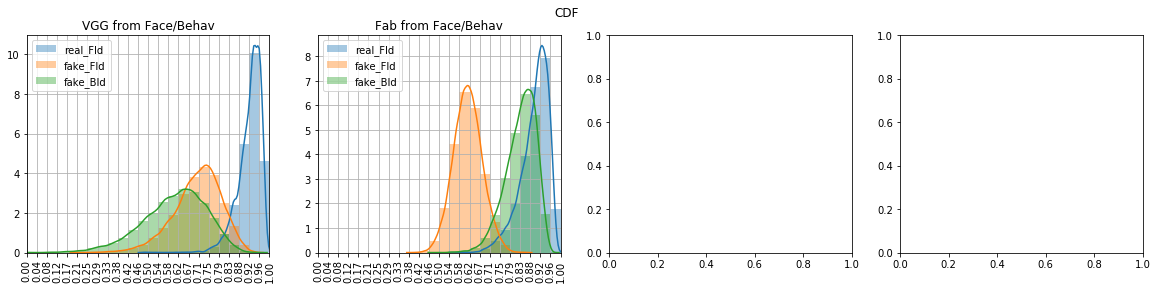

In [23]:
#result_dfs = u.load_obj('cache', 'only_compression_accuracy')

def result_comp():
    
    print('\t\tldr\t\tFF\t\tGG\t\tDFDC\t\tCDF\n')
    print('\n')
    print('Max VGG 0.86', end=' ')
    print_sim_acc(result_dfs, ['ldr_real_100_comp',
                               'FF_real_100_comp',
                               'GG_real_100_comp',
                               'DFDC_real_100_comp',
                               'CDF_real_100_comp'], 
                  'real', 'scaleMaxVGG86_fab040', cur_thres = 0.0001)
    print_sim_acc(result_dfs, ['ldr_fake_100_comp',
                               'FF_fake_100_comp',
                               'GG_fake_100_comp',
                               'DFDC_fake_100_comp',
                               'CDF_fake_100_comp'], 
                  'fake', 'scaleMaxVGG86_fab040', cur_thres = 0.0001)
    
    print('Max VGG 0.88', end=' ')
    print_sim_acc(result_dfs, ['ldr_real_100_comp',
                               'FF_real_100_comp',
                               'GG_real_100_comp',
                               'DFDC_real_100_comp',
                               'CDF_real_100_comp'], 
                  'real', 'scaleMaxVGG88_fab040', cur_thres = 0.0001)
    print_sim_acc(result_dfs, ['ldr_fake_100_comp',
                               'FF_fake_100_comp',
                               'GG_fake_100_comp',
                               'DFDC_fake_100_comp',
                               'CDF_fake_100_comp'], 
                  'fake', 'scaleMaxVGG88_fab040', cur_thres = 0.0001)
    
    print('Max VGG 0.80', end=' ')
    print_sim_acc(result_dfs, ['ldr_real_100_comp',
                               'FF_real_100_comp',
                               'GG_real_100_comp',
                               'DFDC_real_100_comp',
                               'CDF_real_100_comp'], 
                  'real', 'scaleMaxVGG80_fab040', cur_thres = 0.0001)
    print_sim_acc(result_dfs, ['ldr_fake_100_comp',
                               'FF_fake_100_comp',
                               'GG_fake_100_comp',
                               'DFDC_fake_100_comp',
                               'CDF_fake_100_comp'], 
                  'fake', 'scaleMaxVGG80_fab040', cur_thres = 0.0001)

result_comp()

plot_one_row('ldr', '_comp')
plot_one_row('FF', '_comp')
plot_one_row('GG', '_comp')
plot_one_row('DFDC', '_comp')
plot_one_row('CDF', '_comp')



# in wild

In [33]:

result_dfs = {}
#result_dfs['inwild_real_100'] = read_results('result_csv/inwild_real_100_halfRepo.csv')
result_dfs['inwild_sb_fake_100'] = read_results('result_csv/inwild_sb_fake_100_halfRepo.csv')
result_dfs['inwild_tc_fake_100'] = read_results('result_csv/inwild_tc_fake_100_halfRepo.csv')
result_dfs['inwild_be_fake_100'] = read_results('result_csv/inwild_be_fake_100_halfRepo.csv')
result_dfs['inwild_jl_real_100'] = read_results('result_csv/inwild_jl_real_100_halfRepo.csv')
result_dfs['inwild_bh_real_100'] = read_results('result_csv/inwild_bh_real_100_halfRepo.csv')
result_dfs['inwild_an_real_100'] = read_results('result_csv/inwild_an_real_100_halfRepo.csv')



# a plot with ids on the x axis, y axis is vgg/fabnet
def print_sim_acc_comp(in_dict, r_or_f, feat_nm, cur_thres=None):
    
    if r_or_f == 'real':
        keys = ['inwild_jl_real_100', 
               'inwild_bh_real_100',
               'inwild_an_real_100']
    else:
        keys = ['inwild_sb_fake_100', 
               'inwild_tc_fake_100',
               'inwild_be_fake_100']
    
    if cur_thres==None:
        cur_thres = ru.compute_threshold(in_dict, keys, feat_nm, n=1000, cutoff = 0.01)
        print(f': {cur_thres:0.2f}', end='')
    
    print('')
    print(r_or_f, end='|')
    for k in keys:
        cur_acc, cur_optout = ru.compute_accuracy(in_dict[k], feat_nm, cur_thres)
        if r_or_f == 'real':
            print(f'\t{cur_acc:0.2f} ({cur_optout:0.2f})', end=' ')
        else:
            print(f'\t{(1-cur_acc):0.2f} ({cur_optout:0.2f})', end=' ')
                
    
    print('\n---------------------------------------------------------------------------------------------------')
    return cur_thres

# get idividual distances
for k in result_dfs.keys():
    
    # assign behavior ids 
    result_dfs[k]['scaleMaxVGG86_fab040'] = ru.get_comb_Or_scaleMaxVGGFab(result_dfs[k], 
                                                                       mu_sigVGG=(0.86, 0.0001), 
                                                                       mu_sigFab=(0.40, 0.0001))

def result_comp():
    
    print('\t\tSteve B\t\tTom Cruise\t\tBellie Ellish\n')
    print('\n')
    print('1% Reject Max VGG 0.85 Fab 0.4', end=' ')
    print_sim_acc_comp(result_dfs, 'fake', 'scaleMaxVGG86_fab040', cur_thres = 0.0001)
    print_sim_acc_comp(result_dfs, 'real', 'scaleMaxVGG86_fab040', cur_thres = 0.0001)

result_comp()




		Steve B		Tom Cruise		Bellie Ellish



1% Reject Max VGG 0.85 Fab 0.4 
fake|	1.00 (0.00) 	1.00 (0.00) 	1.00 (0.00) 
---------------------------------------------------------------------------------------------------

real|	0.75 (0.00) 	0.95 (0.00) 	1.00 (0.00) 
---------------------------------------------------------------------------------------------------


In [9]:

result_dfs = {}

result_dfs['ldr_real_100'] = read_results('result_csv/ldr_real_100.csv', n=2000)
result_dfs['ldr_fake_100'] = read_results('result_csv/ldr_fake_100.csv', n=2000)
result_dfs['FF_real_100'] = read_results('result_csv/FF_real_100.csv', n=2000)
result_dfs['FF_fake_100'] = read_results('result_csv/FF_fake_100.csv', n=2000)
result_dfs['GG_real_100'] = read_results('result_csv/GG_real_100.csv', n=2000)
result_dfs['GG_fake_100'] = read_results('result_csv/GG_fake_100.csv', n=2000)
result_dfs['DFDC_real_100'] = read_results('result_csv/DFDC_real_100.csv', n=2000)
result_dfs['DFDC_fake_100'] = read_results('result_csv/DFDC_fake_100.csv', n=2000)
result_dfs['CDF_real_100'] = read_results('result_csv/CDF_real_100.csv', n=2000)
result_dfs['CDF_fake_100'] = read_results('result_csv/CDF_fake_100.csv', n=2000)

get_features(result_dfs)
u.save_obj(result_dfs, 'cache', 'all_accuracy')


		ldr		FF		GG		DFDC		SJ



1% Reject Max VGG 0.85 Fab 0.75 
real|	0.99 (0.00) 	0.99 (0.00) 	0.93 (0.00) 	0.93 (0.00) 
---------------------------------------------------------------------------------------------------

fake|	0.96 (0.00) 	0.99 (0.00) 	0.93 (0.00) 	0.72 (0.00) 
---------------------------------------------------------------------------------------------------


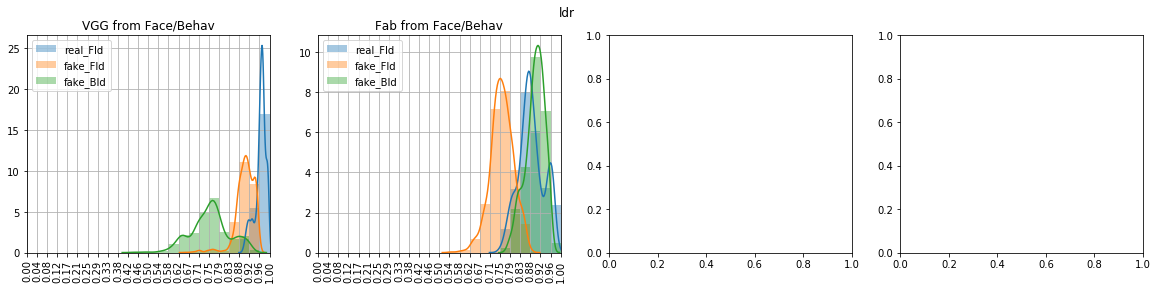

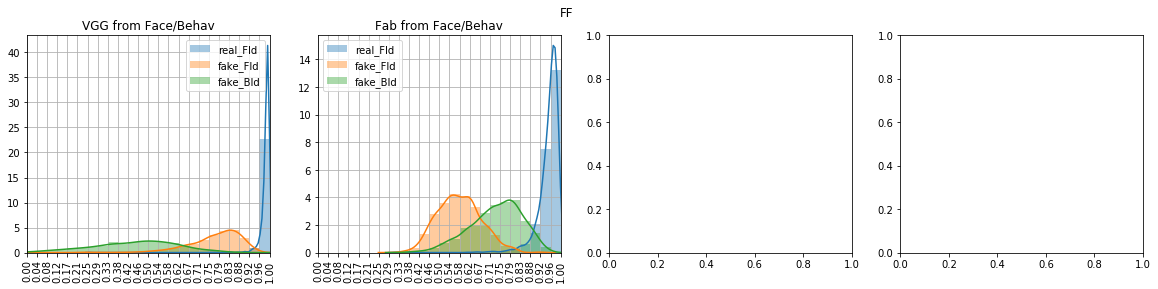

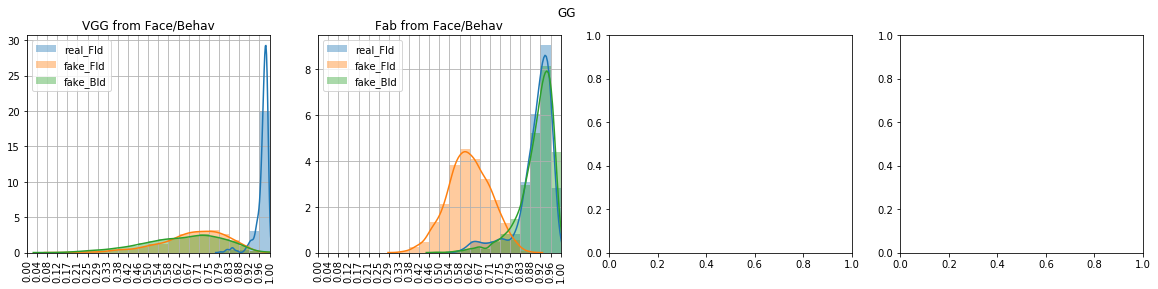

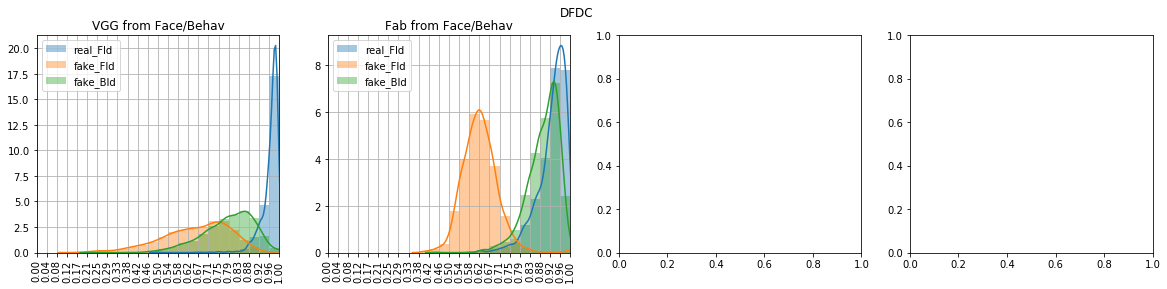

In [12]:

def result_comp():
    
    print('\t\tldr\t\tFF\t\tGG\t\tDFDC\t\tSJ\n')
    print('\n')
    print('1% Reject Max VGG 0.85 Fab 0.75', end=' ')
    print_sim_acc(result_dfs, ['ldr_real_100',
                               'FF_real_100',
                               'GG_real_100',
                               'DFDC_real_100'], 
                  'real', 'scaleMaxVGG85_fab040', cur_thres = 0.0001)
    print_sim_acc(result_dfs, ['ldr_fake_100',
                               'FF_fake_100',
                               'GG_fake_100',
                               'DFDC_fake_100'], 
                  'fake', 'scaleMaxVGG85_fab040', cur_thres = 0.0001)

result_comp()

plot_one_row('ldr', '')
plot_one_row('FF', '')
plot_one_row('GG', '')
plot_one_row('DFDC', '')
#plot_one_row('CDF', 'comp')


In [24]:
# a plot with ids on the x axis, y axis is vgg/fabnet
def print_latex(in_dict):
    
    real_acc = np.zeros((3, ))
    fake_acc = np.zeros((3, ))
    real_opt = np.zeros((3, ))
    fake_opt = np.zeros((3, ))
    
    for k in ['ldr', 'FF', 'GG', 'DFDC', 'CDF']: #
        
        print(k, end=' ')
        c=0
        for f in ['scaleMaxVGG86_fab050', 'scaleMaxVGG86_fab076']:
            
            for r_or_f in ['real', 'fake']:
                
                nm = k + '_' + r_or_f + '_100'
                cur_acc, cur_optout = ru.compute_accuracy(in_dict[nm], f, 0.0001)
                if r_or_f == 'real':
                    cur_acc = cur_acc*100
                    real_acc[c] = real_acc[c] + cur_acc
                    real_opt[c] = real_opt[c] + cur_optout
                else:
                    cur_acc = (1-cur_acc)*100
                    fake_acc[c] = fake_acc[c] + cur_acc
                    fake_opt[c] = fake_opt[c] + cur_optout
                    
                print(f' & ${cur_acc:0.1f}$ (${cur_optout*100:0.1f}$)', end=' ')
            
            c=c+1
            print(' ', end=' ')
            
        print('\\\\ \n')
            
    for i in range(3):

        print(f' & ${real_acc[i]/5:0.1f}$ (${real_opt[i]*100/5:0.1f}$) & ${fake_acc[i]/5:0.1f}$ (${fake_opt[i]*100/5:0.1f}$)', end=' ')
    
print_latex(result_dfs)


ldr  & $99.6$ ($0.0$)  & $95.8$ ($0.0$)    & $99.2$ ($0.0$)  & $95.8$ ($0.0$)   \\ 

FF  & $99.2$ ($0.0$)  & $98.7$ ($0.0$)    & $99.2$ ($0.3$)  & $98.5$ ($43.4$)   \\ 

GG  & $93.1$ ($0.0$)  & $93.2$ ($0.0$)    & $95.2$ ($3.7$)  & $93.1$ ($3.0$)   \\ 

DFDC  & $93.1$ ($0.0$)  & $71.7$ ($0.0$)    & $93.0$ ($0.9$)  & $71.2$ ($2.3$)   \\ 

CDF  & $97.6$ ($0.0$)  & $99.4$ ($0.0$)    & $97.0$ ($0.8$)  & $99.4$ ($5.4$)   \\ 

 & $96.5$ ($0.0$) & $91.8$ ($0.0$)  & $96.7$ ($1.1$) & $91.6$ ($10.8$)  & $0.0$ ($0.0$) & $0.0$ ($0.0$) 

# Threshold ablation

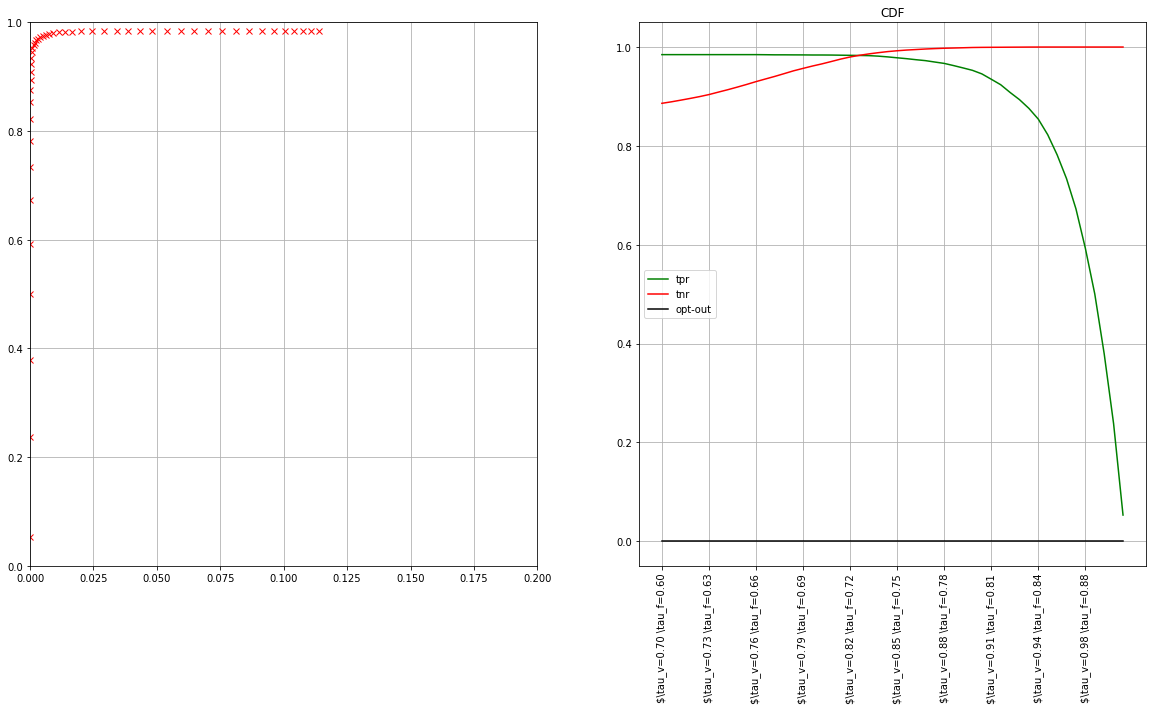

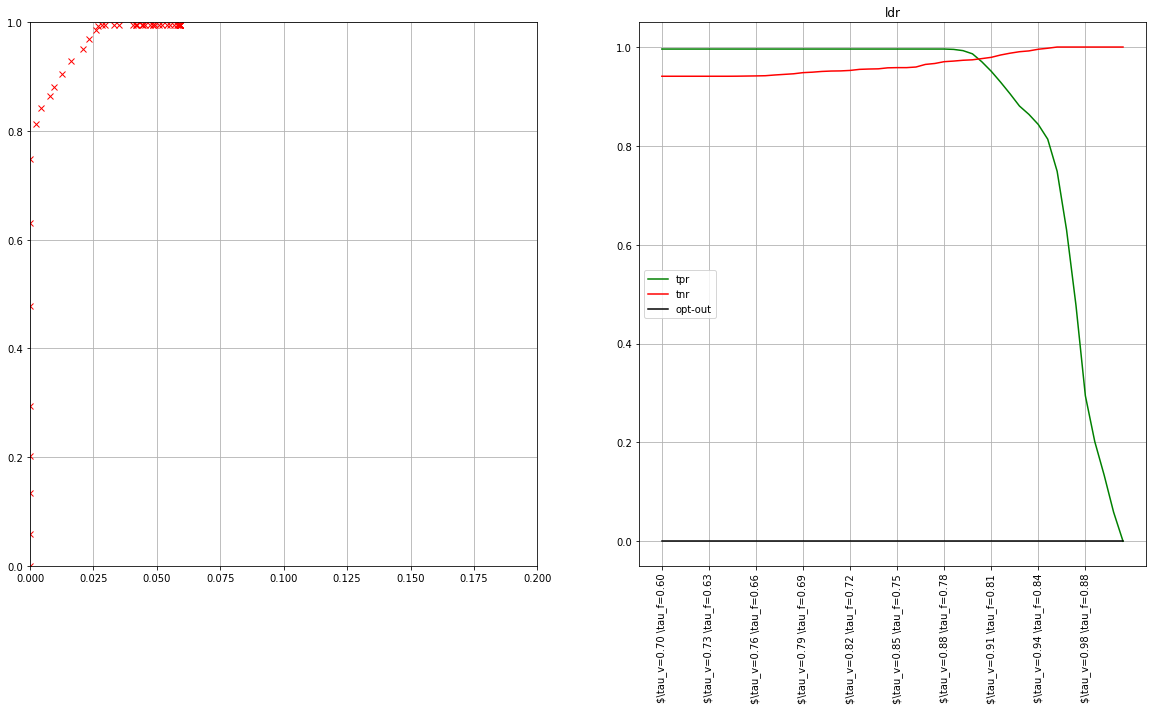

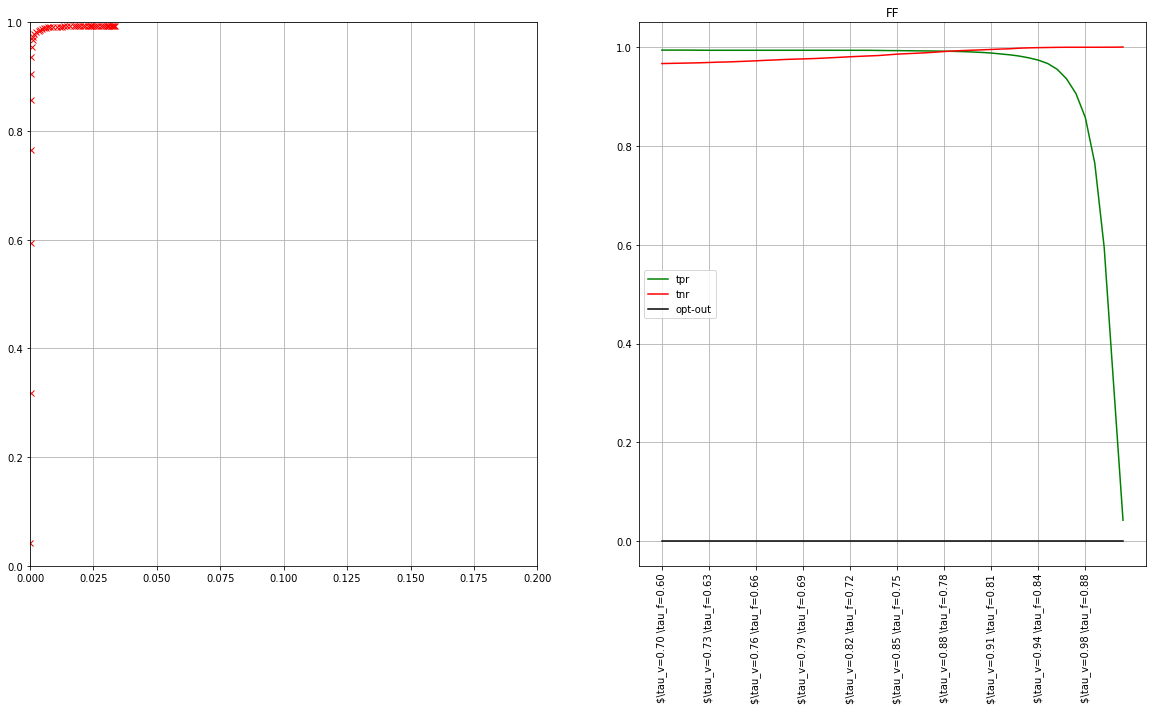

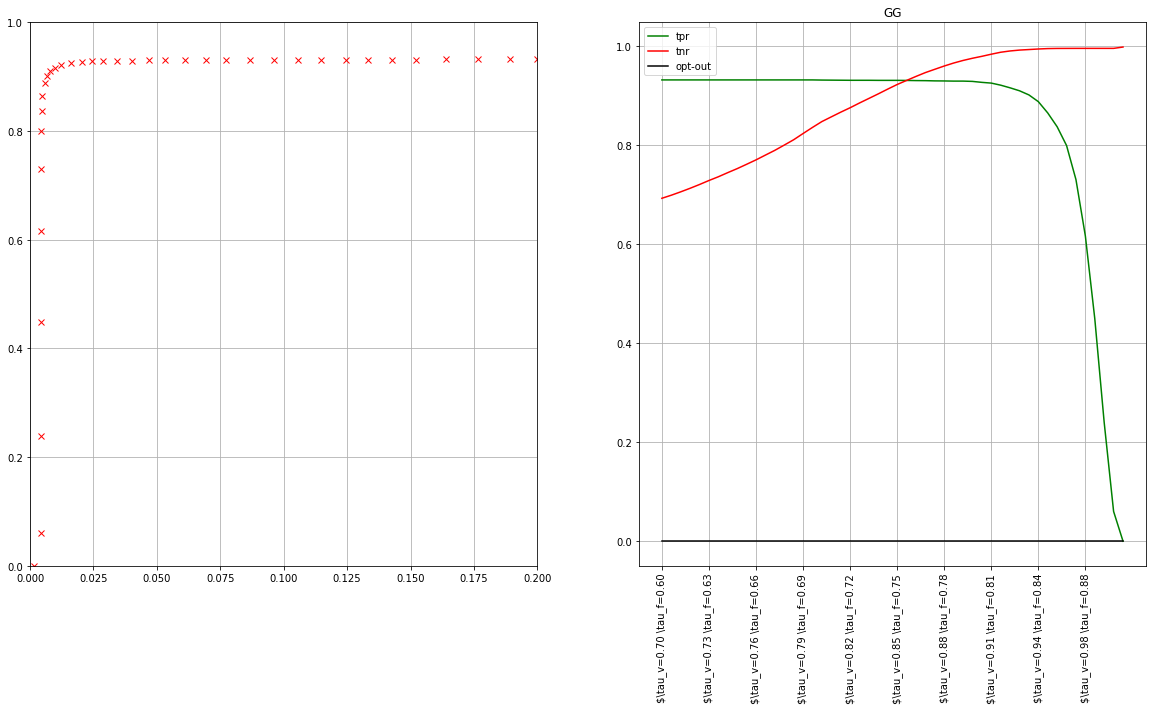

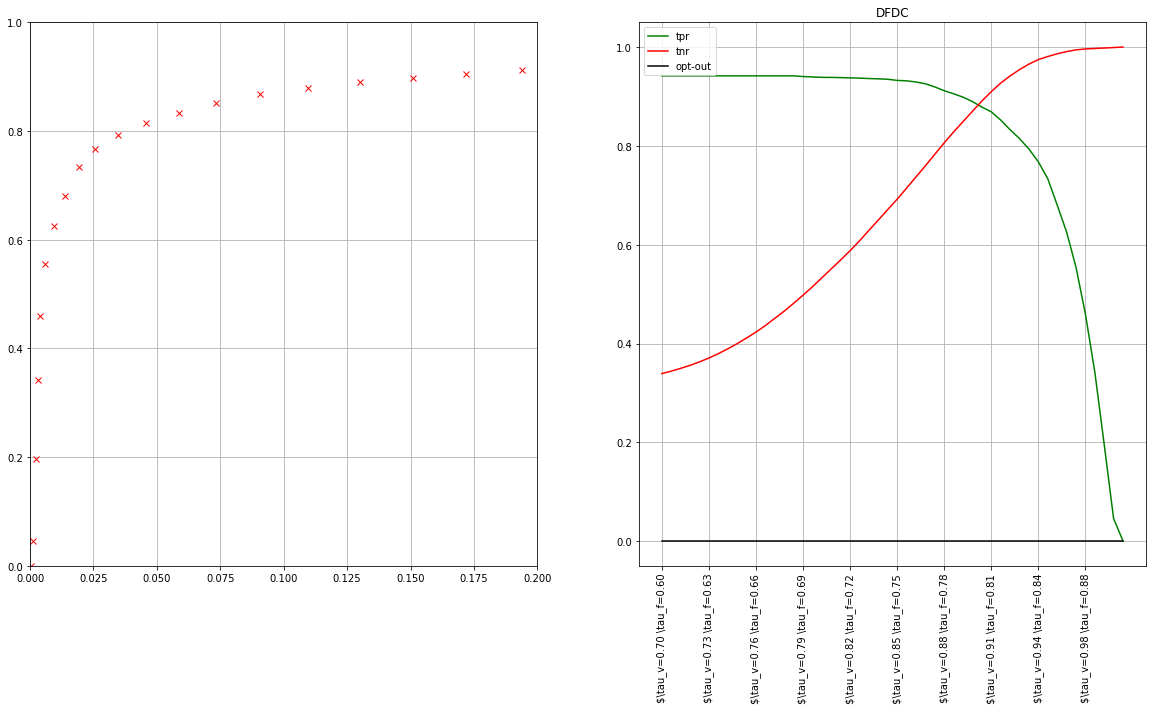

In [29]:

T_v_rng = np.linspace(0.70, 1.0, 50)
T_f_rng = np.linspace(0.60, 0.90, 50)


def compute_acc_optout(in_score, in_thres):
    # non-nan features
    nn_id = np.logical_not(np.isnan(in_score))
    return np.sum(in_score[nn_id]>in_thres)/np.sum(nn_id), (len(in_score)-np.sum(nn_id))/len(in_score)


# get tpr, fpr, optout for one threshold
def get_results(full_df, t_v_rng, t_f_rng):
    
    N = len(t_f_rng)
    acc = np.zeros((N, ))
    acc_opt = np.zeros((N, ))

    for i in range(len(t_f_rng)):
        acc[i], acc_opt[i] = compute_acc_optout(ru.get_comb_Or_scaleMaxVGGFab(full_df, mu_sigVGG=(t_v_rng[i], 0.0001), 
                                                                   mu_sigFab=(0.4, 0.0001)), 0.0001)

    return acc, acc_opt


def get_tpr_fpr_opt_out(in_dict, in_key):

    out_dict = {}
    # real accuracy
    if len(in_key)>1:
        real_df = pd.concat([in_dict[f'{k}_real_100'].sample(n=2000, random_state=0, replace=False) for k in in_key], ignore_index=True, sort=False)
    else:
        real_df = in_dict[f'{in_key[0]}_real_100']

    tpr, r_op = get_results(real_df, T_v_rng, T_f_rng)

    # fake failure
    if len(in_key)>1:
        fake_df = pd.concat([in_dict[f'{k}_fake_100'].sample(n=2000, random_state=0, replace=False) for k in in_key], ignore_index=True, sort=False)
    else:
        fake_df = in_dict[f'{in_key[0]}_fake_100']
    fpr, f_op = get_results(fake_df, T_v_rng, T_f_rng)

    # opt out
    opt_out = (r_op + f_op)/2
    
    out_dict['fpr'] = fpr
    out_dict['tpr'] = tpr
    out_dict['opt_out'] = opt_out
    
    return out_dict

keys = ['CDF', 'ldr', 'FF', 'GG', 'DFDC'] #, 
out_result = {}
for k in keys:
    
    out_result[k] = u.load_obj('cache', f'accuracy_{k}')
    if out_result[k] is None:
        out_result[k] = get_tpr_fpr_opt_out(result_dfs, [k])
        u.save_obj(save_results, 'cache', f'accuracy_{k}')
        
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax[0].plot(out_result[k]['fpr'], out_result[k]['tpr'], 'rx')
    ax[0].grid(b=True)
    ax[0].set_ylim([0.0, 1.0])
    ax[0].set_xlim([0., .2])

    ax[1].plot(out_result[k]['tpr'], 'g-', label='tpr')
    ax[1].plot(1-out_result[k]['fpr'], 'r-', label='tnr')
    ax[1].plot(out_result[k]['opt_out'], 'k-', label='opt-out')
    ax[1].set_xticks(np.arange(0, len(out_result[k]['fpr']), 5))
    ax[1].set_xticklabels([fr'$\tau_v={T_v_rng[x]:.2f} \tau_f={T_f_rng[x]:.2f}' for x in np.arange(0, len(out_result[k]['fpr']), 5)], rotation=90)
    ax[1].grid(b=True)
    ax[1].set_title(k)
    ax[1].legend()
    plt.show()
    

out_result['all'] = get_tpr_fpr_opt_out(result_dfs, keys)
u.save_obj(out_result, 'ECCV20_figures', 'tpr_fpr_results')


In [ ]:


# plot single roc
# threshold value for accuracy to report for a t_v and t_f, and threshold values for one opt-out perc
def plot_tpr_tnr(in_key, out_file, t_idx = 0, in_op=0.1, print_labels=True):

    save_results = load_obj('data', 'tpr_fpr_results')
    tpr = save_results[in_key]['tpr']
    fpr = save_results[in_key]['fpr']

    # print the values
    print(f'{out_file}')
    print(f'Given Threshold: T_v:{T_v_rng[t_idx]:.2f} Real: {tpr[t_idx]:.5f} Fake: {(1-fpr[t_idx]):.5f} ')# accuracy at a threshold
    c_idx = np.argmin(np.abs(tpr-(1-fpr)))
    print(f'Cross Over: T_v:{T_v_rng[c_idx]:.2f} Real: {tpr[c_idx]:.5f} Fake: {(1-fpr[c_idx]):.5f} ')

    #plot
    _, ax = plt.subplots(figsize=(4, 4))
    #ax.plot(tpr * 100, 'g-', label='real')
    #ax.plot((1-fpr)*100, 'r-', label='fake')

    ax.plot(fpr, tpr)

    new_fpr = np.concatenate(([1], fpr, [0]), axis=0)
    new_tpr = np.concatenate(([0], tpr, [1]), axis=0)
    roc_auc = auc(new_fpr, new_tpr)
    print(f'AUC:{roc_auc}')


    ax.set_xlim([2, 48])
    xticks = np.arange(8, len(fpr)-5, 8)
    ax.set_xticks(xticks)
    ax.set_xticklabels([fr'${T_v_rng[x]:.2f}$' for x in xticks]) #, fontdict={'size': 14}

    #xlabel
    ax.set_xlabel(r'$\tau_f$', fontdict={'size': 16})
    ax.xaxis.set_label_coords(1.06, 0.02) # location of xlabel
    if print_labels:
        ax.legend(loc='center left', fontsize=16)
        ax.yaxis.label.set_color('black')
    else:
        ax.yaxis.label.set_color('white')


    ax.grid(b=True)
    ax.set_yticks(np.linspace(0, 100, 5))
    ax.set_ylabel('percent', fontdict={'size': 16})
    plt.tight_layout(pad=0., h_pad=None, w_pad=None, rect=None)
    plt.show()


t_idx = 25
plot_tpr_tnr('ldr', 'figures/ldr_acc.eps', t_idx = t_idx, in_op=0.1, print_labels=False)
plot_tpr_tnr('FF', 'figures/FF_acc.eps', t_idx = t_idx, in_op=0.1, print_labels=False)
plot_tpr_tnr('DFDC', 'figures/DFDC_acc.eps', t_idx = t_idx, in_op=0.1, print_labels=False)
plot_tpr_tnr('CDF', 'figures/CDF_acc.eps', t_idx = t_idx, in_op=0.1, print_labels=False)
plot_tpr_tnr('GG', 'figures/DFD_acc.eps', t_idx = t_idx, in_op=0.1, print_labels=True)
plot_tpr_tnr('all', 'figures/ALL_acc.eps', t_idx=t_idx, in_op=0.05565, print_labels=True)




## plot individual distance from face and behav id or agnostic

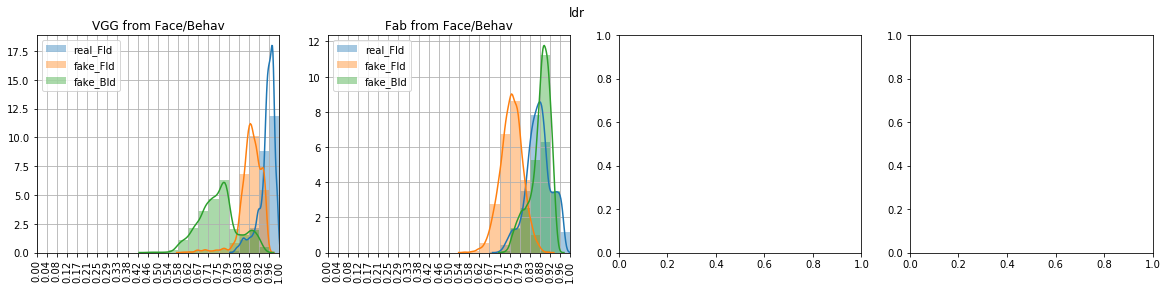

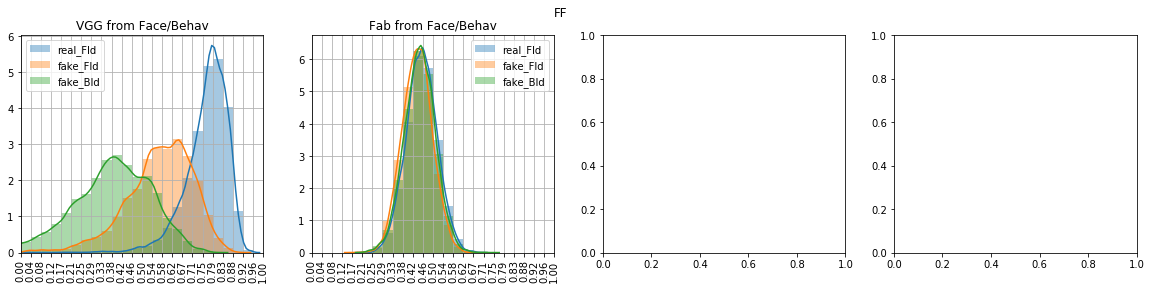

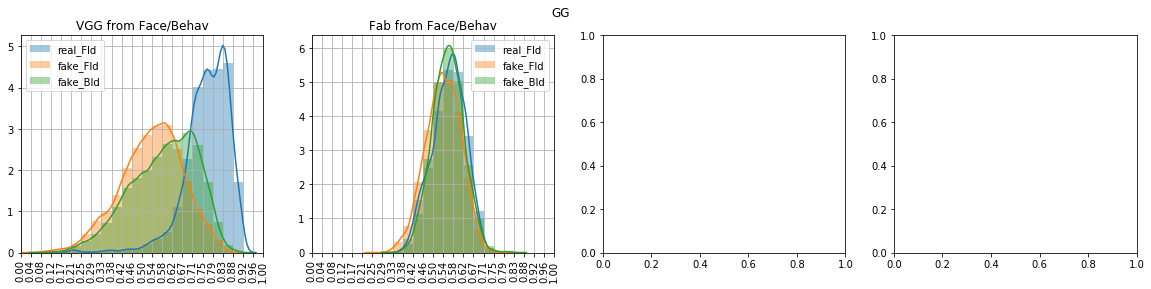

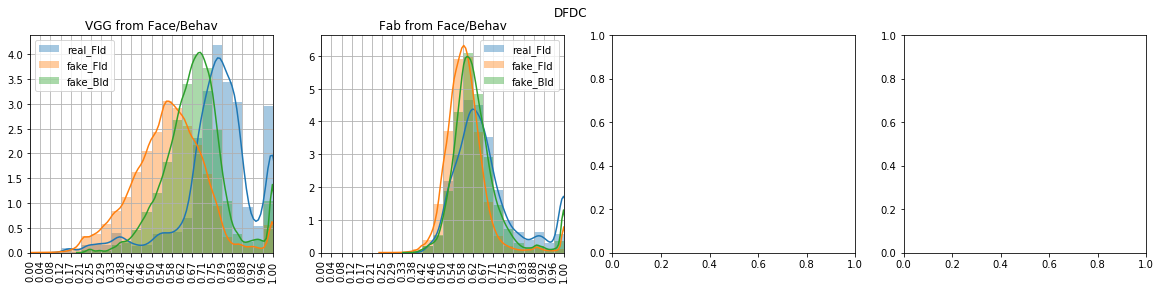

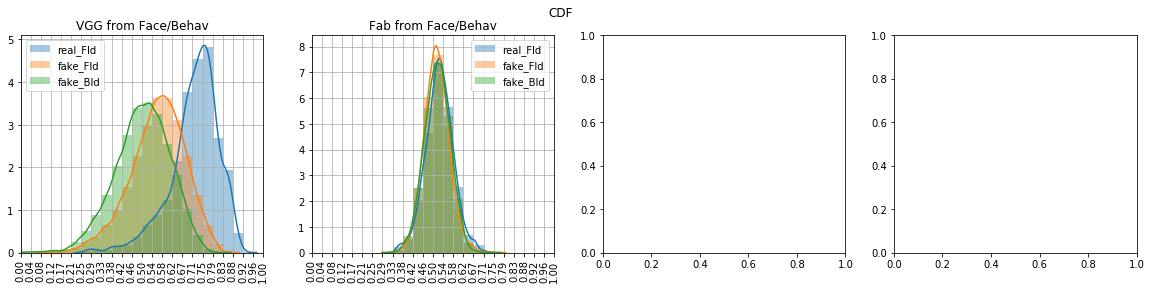

In [42]:

def plot_distribution(in_dict, in_keys, in_feat_nms, in_leg, title, ax):
    
    bins = np.linspace(0, 1, 25)
    for i in range(len(in_keys)):
        
        cur_arr = np.array(in_dict[in_keys[i]][in_feat_nms[i]].dropna())
        if np.std(cur_arr) == 0:
            cur_arr = cur_arr + np.random.normal(loc=0, scale=0.01, size=cur_arr.shape)
        sns.distplot(cur_arr, 
                     bins=bins, label=in_leg[i], ax=ax)
        ax.set_xticks(bins)
        ax.set_xticklabels([f'{x:.2f}' for x in bins], rotation=90)
        ax.legend()
        ax.set_title(title)
        ax.set_xlim([0.0, 1.0])
        ax.grid(b=True)
        

# plot the distances
def plot_one_row(in_pref):
    
    _, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
    real_key = in_pref + '_real_100_comp'
    fake_key = in_pref + '_fake_100_comp'
    
    plot_distribution(result_dfs, 
                      [real_key, fake_key, fake_key], 
                      ['vgg_face_id_sim', 'vgg_face_id_sim', 'vgg_behav_id_sim'], 
                      ['real_FId', 'fake_FId', 'fake_BId'], 'VGG from Face/Behav', ax=ax[0])
    plot_distribution(result_dfs, 
                      [real_key, fake_key, fake_key], 
                      ['fab_face_id_sim', 'fab_face_id_sim', 'fab_behav_id_sim'], 
                      ['real_FId', 'fake_FId', 'fake_BId'], 'Fab from Face/Behav', ax=ax[1])
    plt.suptitle(in_pref)
    plt.show()
    
plot_one_row('ldr')
plot_one_row('FF')
plot_one_row('GG')
plot_one_row('DFDC')
#plot_one_row('SJ')
plot_one_row('CDF')


# get the DFDC sample fake videos

In [38]:
temp = result_dfs['DFDC_fake_100'].loc[:, ['fileName', 'vgg_face_id_sim', 'fab_behav_id_sim']].copy()

In [41]:
temp['diff'] = np.array(temp['vgg_face_id_sim']) - np.array(temp['fab_behav_id_sim'])

In [ ]:

display(temp.loc[temp['vgg_face_id_sim'] < temp['fab_behav_id_sim'], :].sort_values(by='diff', ascending=True).iloc[
    1000:, :])


## print accuracies

In [13]:
# a plot with ids on the x axis, y axis is vgg/fabnet
def print_sim_acc_row(in_dict, r_or_f, feat_nm, cur_thres=None, cutoff = 0.01):
    
    if r_or_f == 'real':
        keys = ['ldr_real_100',
                'FF_real_100',
                'GG_real_100',
                'DFDC_real_100', 
                'SJ_real_100',
               'CDF_real_100']
    else:
        keys = ['ldr_fake_100',
                'FF_fake_100',
                'GG_fake_100',
                'DFDC_fake_100', 
                'SJ_fake_100',
               'CDF_fake_100']
    
    if cur_thres==None:
        cur_thres = ru.compute_threshold(in_dict, keys, feat_nm, n=1000, cutoff = cutoff)
        print(f': {cur_thres:0.2f}', end='')
    
    print('')
    print(r_or_f, end='|')
    for k in keys:
        cur_acc, cur_optout = ru.compute_accuracy(in_dict[k], feat_nm, cur_thres)
        if r_or_f == 'real':
            print(f'\t{cur_acc:0.2f} ({cur_optout:0.2f})', end=' ')
        else:
            print(f'\t{(1-cur_acc):0.2f} ({cur_optout:0.2f})', end=' ')
                
    
    print('\n---------------------------------------------------------------------------------------------------')
    return cur_thres


    
def result_per_measure():
    
    print('\t\t\t1% reject')
    print('\t\tldr\t\tFF\t\tGG\t\tDFDC\t\tSJ\t\tCDF\n')
    print('Only Fab', end=' ')
    cur_thres = print_sim_acc_row(result_dfs, 'real', 'only_fab', cutoff = 0.01)
    print_sim_acc_row(result_dfs, 'fake', 'only_fab', cur_thres)
    print('\n')
    print('Only VGG', end=' ')
    cur_thres = print_sim_acc_row(result_dfs, 'real', 'only_vgg', cutoff = 0.01)
    print_sim_acc_row(result_dfs, 'fake', 'only_vgg', cur_thres)
    print('\n---------------------------------------------------------------------------------------------------\n')
    
    print('\t\t\t2% reject')
    print('\t\tldr\t\tFF\t\tGG\t\tDFDC\t\tSJ\n')
    print('Only Fab', end=' ')
    cur_thres = print_sim_acc_row(result_dfs, 'real', 'only_fab', cutoff = 0.02)
    print_sim_acc_row(result_dfs, 'fake', 'only_fab', cur_thres)
    print('\n')
    print('Only VGG', end=' ')
    cur_thres = print_sim_acc_row(result_dfs, 'real', 'only_vgg', cutoff = 0.02)
    print_sim_acc_row(result_dfs, 'fake', 'only_vgg', cur_thres)
    print('\n---------------------------------------------------------------------------------------------------\n')
    
    print('\t\t\t5% reject')
    print('\t\tldr\t\tFF\t\tGG\t\tDFDC\t\tSJ\n')
    print('Only Fab', end=' ')
    cur_thres = print_sim_acc_row(result_dfs, 'real', 'only_fab', cutoff = 0.05)
    print_sim_acc_row(result_dfs, 'fake', 'only_fab', cur_thres)
    print('\n')
    print('Only VGG', end=' ')
    cur_thres = print_sim_acc_row(result_dfs, 'real', 'only_vgg', cutoff = 0.05)
    print_sim_acc_row(result_dfs, 'fake', 'only_vgg', cur_thres)

result_per_measure()

			1% reject
		ldr		FF		GG		DFDC		SJ		CDF

Only Fab : 0.76
real|	1.00 (0.00) 	0.99 (0.00) 	0.99 (0.00) 	1.00 (0.00) 	0.97 (0.00) 	0.98 (0.00) 
---------------------------------------------------------------------------------------------------

fake|	0.00 (0.00) 	0.45 (0.00) 	0.04 (0.00) 	0.04 (0.00) 	0.14 (0.00) 	0.06 (0.00) 
---------------------------------------------------------------------------------------------------


Only VGG : 0.86
real|	1.00 (0.00) 	1.00 (0.00) 	1.00 (0.00) 	1.00 (0.00) 	0.97 (0.00) 	0.99 (0.00) 
---------------------------------------------------------------------------------------------------

fake|	0.06 (0.00) 	0.76 (0.00) 	0.88 (0.00) 	0.69 (0.00) 	1.00 (0.00) 	0.89 (0.00) 
---------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------

			2% reject
		ldr		FF		GG		DFDC		SJ

Only Fab : 0.78
real|	1.00 (0.00) 	0.99 (0.00

In [40]:

# a plot with ids on the x axis, y axis is vgg/fabnet
def print_sim_acc_row(in_dict, r_or_f, feat_nm, cur_thres=None, cutoff = 0.01):
    
    if r_or_f == 'real':
        keys = ['SJ_real_100']
    else:
        keys = ['SJ_fake_100']
    
    if cur_thres==None:
        cur_thres = ru.compute_threshold(in_dict, keys, feat_nm, n=1000, cutoff = cutoff)
        print(f': {cur_thres:0.2f}', end='')
    
    print('')
    print(r_or_f, end='|')
    for k in keys:
        cur_acc, cur_optout = ru.compute_accuracy(in_dict[k], feat_nm, cur_thres)
        if r_or_f == 'real':
            print(f'\t{cur_acc:0.2f} ({cur_optout:0.2f})', end=' ')
        else:
            print(f'\t{(1-cur_acc):0.2f} ({cur_optout:0.2f})', end=' ')
                
    
    print('\n---------------------------------------------------------------------------------------------------')
    return cur_thres


    
def result_per_measure():
    
    print('\t\t\t1% reject')
    print('\t\tldr\t\tFF\t\tGG\t\tDFDC\t\tSJ\t\tCDF\n')
    print('Max VGG 0.86 Fab 0.76', end=' ')
    print_sim_acc_row(result_dfs, 'real', 'scaleMaxVGG86_fab076', cur_thres = 0.0001)
    print_sim_acc_row(result_dfs, 'fake', 'scaleMaxVGG86_fab076', cur_thres = 0.0001)
    print('\n---------------------------------------------------------------------------------------------------\n')
    
    print('\t\t\t2% reject')
    print('\t\tldr\t\tFF\t\tGG\t\tDFDC\t\tSJ\t\tCDF\n')
    print('\n')
    print('Max VGG 0.90 Fab 0.78', end=' ')
    print_sim_acc_row(result_dfs, 'real', 'scaleMaxVGG90_fab078', cur_thres = 0.0001)
    print_sim_acc_row(result_dfs, 'fake', 'scaleMaxVGG90_fab078', cur_thres = 0.0001)
    print('\n---------------------------------------------------------------------------------------------------\n')
    
result_per_measure()


			1% reject
		ldr		FF		GG		DFDC		SJ		CDF

Max VGG 0.86 Fab 0.76 
real|	0.86 (0.35) 
---------------------------------------------------------------------------------------------------

fake|	1.00 (0.34) 
---------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------

			2% reject
		ldr		FF		GG		DFDC		SJ		CDF



Max VGG 0.90 Fab 0.78 
real|	0.91 (0.48) 
---------------------------------------------------------------------------------------------------

fake|	1.00 (0.64) 
---------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------



In [18]:
# get idividual distances
for k in result_dfs.keys():
    
    # assign behavior ids 
    result_dfs[k]['actualLabel_behav'] = ru.get_behav_id(result_dfs[k])
    result_dfs[k]['vgg_behav_id_sim'] = ru.get_vgg_behav_id(result_dfs[k])
    result_dfs[k]['vgg_face_id_sim'] = ru.get_vgg_face_id(result_dfs[k])
    result_dfs[k]['fab_face_id_sim'] = ru.get_fab_face_id(result_dfs[k])
    result_dfs[k]['fab_behav_id_sim'] = ru.get_fab_behav_id(result_dfs[k])
    result_dfs[k]['only_fab'] = ru.get_max_fab(result_dfs[k])
    result_dfs[k]['only_vgg'] = ru.get_max_vgg(result_dfs[k])
    result_dfs[k]['scaleMaxVGG85_fab075'] = ru.get_comb_Or_scaleMaxVGGFab(result_dfs[k], 
                                                                       mu_sigVGG=(0.85, 0.0001), 
                                                                       mu_sigFab=(0.75, 0.0001))

# a plot with ids on the x axis, y axis is vgg/fabnet
def print_latex(in_dict):
    
    real_acc = np.zeros((3, ))
    fake_acc = np.zeros((3, ))
    real_opt = np.zeros((3, ))
    fake_opt = np.zeros((3, ))
    
    for k in ['ldr', 'FF', 'GG', 'DFDC', 'CDF']:
        
        print(k, end=' ')
        c=0
        for f in ['scaleMaxVGG86_fab076', 'scaleMaxVGG90_fab078', 'scaleMaxVGG92_fab082']:
            
            for r_or_f in ['real', 'fake']:
                
                nm = k + '_' + r_or_f + '_100'
                cur_acc, cur_optout = ru.compute_accuracy(in_dict[nm], f, 0.0001)
                if r_or_f == 'real':
                    cur_acc = cur_acc*100
                    real_acc[c] = real_acc[c] + cur_acc
                    real_opt[c] = real_opt[c] + cur_optout
                else:
                    cur_acc = (1-cur_acc)*100
                    fake_acc[c] = fake_acc[c] + cur_acc
                    fake_opt[c] = fake_opt[c] + cur_optout
                    
                print(f' & ${cur_acc:0.1f}$ (${cur_optout*100:0.1f}$)', end=' ')
            
            c=c+1
            print(' ', end=' ')
            
        print('\\\\ \n')
            
    for i in range(3):

        print(f' & ${real_acc[i]/5:0.1f}$ (${real_opt[i]*100/5:0.1f}$) & ${fake_acc[i]/5:0.1f}$ (${fake_opt[i]*100/5:0.1f}$)', end=' ')
    
print_latex(result_dfs)

ldr  & $100.0$ ($0.0$)  & $96.4$ ($0.0$)    & $97.9$ ($0.0$)  & $97.6$ ($0.2$)    & $90.2$ ($1.4$)  & $98.2$ ($4.8$)   \\ 

FF  & $99.6$ ($0.6$)  & $98.5$ ($44.6$)    & $99.6$ ($0.9$)  & $99.1$ ($56.3$)    & $99.5$ ($1.8$)  & $99.2$ ($76.2$)   \\ 

GG  & $99.4$ ($0.9$)  & $94.2$ ($4.4$)    & $99.3$ ($1.3$)  & $97.9$ ($7.1$)    & $99.3$ ($3.6$)  & $99.0$ ($17.3$)   \\ 

DFDC  & $96.0$ ($0.1$)  & $73.0$ ($4.2$)    & $95.6$ ($0.3$)  & $87.3$ ($7.2$)    & $95.1$ ($1.2$)  & $92.7$ ($17.5$)   \\ 

CDF  & $98.7$ ($1.7$)  & $99.4$ ($6.0$)    & $97.1$ ($2.8$)  & $99.9$ ($9.7$)    & $96.0$ ($6.9$)  & $99.9$ ($21.2$)   \\ 

 & $98.7$ ($0.7$) & $92.3$ ($11.9$)  & $97.9$ ($1.1$) & $96.4$ ($16.1$)  & $96.0$ ($3.0$) & $97.8$ ($27.4$) 

In [ ]:


    
def result_per_measure():
    
    print('\t\t\t1% reject')
    print('\t\tldr\t\tFF\t\tGG\t\tDFDC\t\tSJ\t\tCDF\n')
    print('Max VGG 0.86 Fab 0.76', end=' ')
    print_sim_acc_row(result_dfs, 'real', 'scaleMaxVGG86_fab076', cur_thres = 0.0001)
    print_sim_acc_row(result_dfs, 'fake', 'scaleMaxVGG86_fab076', cur_thres = 0.0001)
    print('\n---------------------------------------------------------------------------------------------------\n')
    
    print('\t\t\t2% reject')
    print('\t\tldr\t\tFF\t\tGG\t\tDFDC\t\tSJ\t\tCDF\n')
    print('\n')
    print('Max VGG 0.90 Fab 0.78', end=' ')
    print_sim_acc_row(result_dfs, 'real', 'scaleMaxVGG90_fab078', cur_thres = 0.0001)
    print_sim_acc_row(result_dfs, 'fake', 'scaleMaxVGG90_fab078', cur_thres = 0.0001)
    print('\n---------------------------------------------------------------------------------------------------\n')
    
    print('\t\t\t5% reject')
    print('\t\tldr\t\tFF\t\tGG\t\tDFDC\t\tSJ\t\tCDF\n')
    print('\n')
    print('Max VGG 0.92 Fab 0.82', end=' ')
    print_sim_acc_row(result_dfs, 'real', 'scaleMaxVGG92_fab082', cur_thres = 0.0001)
    print_sim_acc_row(result_dfs, 'fake', 'scaleMaxVGG92_fab082', cur_thres = 0.0001)
    print('\n---------------------------------------------------------------------------------------------------\n')
    
result_per_measure()


In [10]:
# a plot with ids on the x axis, y axis is vgg/fabnet
def print_sim_acc_row(in_dict, r_or_f, feat_nm, cur_thres=None, cutoff = 0.01):
    
    if r_or_f == 'real':
        keys = ['ldr_real_100',
                'FF_real_100',
                'GG_real_100',
                'DFDC_real_100', 
                'SJ_real_100',
               'CDF_real_100']
    else:
        keys = ['ldr_fake_100',
                'FF_fake_100',
                'GG_fake_100',
                'DFDC_fake_100', 
                'SJ_fake_100',
               'CDF_fake_100']
    
    if cur_thres==None:
        cur_thres = ru.compute_threshold(in_dict, keys, feat_nm, n=1000, cutoff = cutoff)
        print(f': {cur_thres:0.2f}', end='')
    
    print('')
    print(r_or_f, end='|')
    for k in keys:
        cur_acc, cur_optout = ru.compute_accuracy(in_dict[k], feat_nm, cur_thres)
        if r_or_f == 'real':
            print(f'\t{cur_acc*100:0.1f} ({cur_optout*100:0.1f})', end=' ')
        else:
            print(f'\t{(1-cur_acc)*100:0.1f} ({cur_optout*100:0.1f})', end=' ')
                
    
    print('\n---------------------------------------------------------------------------------------------------')
    return cur_thres


    
def result_per_measure():
    
    print('\t\t\t1% reject')
    print('\t\tldr\t\tFF\t\tGG\t\tDFDC\t\tSJ\t\tCDF\n')
    print('Max VGG 0.86 Fab 0.76', end=' ')
    print_sim_acc_row(result_dfs, 'real', 'scaleMaxVGG86_fab076', cur_thres = 0.0001)
    print_sim_acc_row(result_dfs, 'fake', 'scaleMaxVGG86_fab076', cur_thres = 0.0001)
    print('\n---------------------------------------------------------------------------------------------------\n')
    
    print('\t\t\t2% reject')
    print('\t\tldr\t\tFF\t\tGG\t\tDFDC\t\tSJ\t\tCDF\n')
    print('\n')
    print('Max VGG 0.90 Fab 0.78', end=' ')
    print_sim_acc_row(result_dfs, 'real', 'scaleMaxVGG90_fab078', cur_thres = 0.0001)
    print_sim_acc_row(result_dfs, 'fake', 'scaleMaxVGG90_fab078', cur_thres = 0.0001)
    print('\n---------------------------------------------------------------------------------------------------\n')
    
    print('\t\t\t5% reject')
    print('\t\tldr\t\tFF\t\tGG\t\tDFDC\t\tSJ\t\tCDF\n')
    print('\n')
    print('Max VGG 0.92 Fab 0.82', end=' ')
    print_sim_acc_row(result_dfs, 'real', 'scaleMaxVGG92_fab082', cur_thres = 0.0001)
    print_sim_acc_row(result_dfs, 'fake', 'scaleMaxVGG92_fab082', cur_thres = 0.0001)
    print('\n---------------------------------------------------------------------------------------------------\n')
    
result_per_measure()

			1% reject
		ldr		FF		GG		DFDC		SJ		CDF

Max VGG 0.86 Fab 0.76 
real|	100.0 (0.0) 	99.6 (0.6) 	99.4 (0.9) 	96.0 (0.1) 	85.8 (35.5) 	98.7 (1.7) 
---------------------------------------------------------------------------------------------------

fake|	96.4 (0.0) 	98.5 (44.6) 	94.2 (4.4) 	73.0 (4.2) 	100.0 (34.3) 	99.4 (6.0) 
---------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------

			2% reject
		ldr		FF		GG		DFDC		SJ		CDF



Max VGG 0.90 Fab 0.78 
real|	97.9 (0.0) 	99.6 (0.9) 	99.3 (1.3) 	95.6 (0.3) 	91.3 (48.4) 	97.1 (2.8) 
---------------------------------------------------------------------------------------------------

fake|	97.6 (0.2) 	99.1 (56.3) 	97.9 (7.1) 	87.3 (7.2) 	100.0 (64.0) 	99.9 (9.7) 
---------------------------------------------------------------------------------------------------

----------------------------------------

# compression


In [20]:
# a plot with ids on the x axis, y axis is vgg/fabnet
def print_sim_acc_comp(in_dict, r_or_f, feat_nm, cur_thres=None):
    
    if r_or_f == 'real':
        keys = ['ldr_real_100_comp',
                'FF_real_100_comp',
                'GG_real_100_comp',
                'DFDC_real_100_comp']
    else:
        keys = ['ldr_fake_100_comp',
                'FF_fake_100_comp',
                'GG_fake_100_comp',
                'DFDC_fake_100_comp']
    
    if cur_thres==None:
        cur_thres = ru.compute_threshold(in_dict, keys, feat_nm, n=1000, cutoff = 0.01)
        print(f': {cur_thres:0.2f}', end='')
    
    print('')
    print(r_or_f, end='|')
    for k in keys:
        cur_acc, cur_optout = ru.compute_accuracy(in_dict[k], feat_nm, cur_thres)
        if r_or_f == 'real':
            print(f'\t{cur_acc:0.2f} ({cur_optout:0.2f})', end=' ')
        else:
            print(f'\t{(1-cur_acc):0.2f} ({cur_optout:0.2f})', end=' ')
                
    
    print('\n---------------------------------------------------------------------------------------------------')
    return cur_thres


    
def result_comp():
    
    print('\t\tldr\t\tFF\t\tGG\t\tDFDC\t\tSJ\n')
    print('\n')
    print('1% Reject Max VGG 0.86 Fab 0.76', end=' ')
    print_sim_acc_comp(result_dfs, 'real', 'scaleMaxVGG86_fab076', cur_thres = 0.0001)
    print_sim_acc_comp(result_dfs, 'fake', 'scaleMaxVGG86_fab076', cur_thres = 0.0001)
    print('\n')
    print('2% reject Max VGG 0.90 Fab 0.78', end=' ')
    print_sim_acc_comp(result_dfs, 'real', 'scaleMaxVGG90_fab078', cur_thres = 0.0001)
    print_sim_acc_comp(result_dfs, 'fake', 'scaleMaxVGG90_fab078', cur_thres = 0.0001)

result_comp()



		ldr		FF		GG		DFDC		SJ



1% Reject Max VGG 0.86 Fab 0.76 
real|	1.00 (0.00) 	0.97 (0.01) 	0.99 (0.01) 	0.87 (0.01) 
---------------------------------------------------------------------------------------------------

fake|	0.93 (0.01) 	0.99 (0.52) 	0.95 (0.06) 	0.82 (0.09) 
---------------------------------------------------------------------------------------------------


2% reject Max VGG 0.90 Fab 0.78 
real|	0.92 (0.00) 	0.92 (0.01) 	0.97 (0.01) 	0.81 (0.01) 
---------------------------------------------------------------------------------------------------

fake|	0.97 (0.03) 	0.99 (0.63) 	0.98 (0.10) 	0.94 (0.15) 
---------------------------------------------------------------------------------------------------


# plot the accuracies

In [60]:
# plot the dataset accuracies
# a plot with ids on the x axis, y axis is vgg/fabnet
def plot_sim_acc(in_dict, r_or_fs, feat_nm, cur_thres, ax):
    
    dataset_nm = ['ldr', 'FF', 'GG', 'DFDC', 'CDF', 'SJ']
    avg_acc = {}
    avg_opt = {}
    
    for k in dataset_nm:
        avg_acc[k] = 0
        avg_opt[k] = 0
    
    for r_or_f in r_or_fs:
        
        for k in dataset_nm:
            
            if r_or_f == 'real':
                cur_key = f'{k}_real_100'
            else:
                cur_key = f'{k}_fake_100'
        
            cur_acc, cur_optout = ru.compute_accuracy(in_dict[cur_key], feat_nm, cur_thres)
            if r_or_f == 'real':
                avg_acc[k] = avg_acc[k] + cur_acc
            else:
                avg_acc[k] = avg_acc[k] + (1-cur_acc)
            avg_opt[k] = avg_opt[k] + cur_optout
        
    # plot the data points
    ax[0].plot(np.arange(len(dataset_nm)), [avg_acc[k]/len(r_or_fs) for k in dataset_nm], label=feat_nm)
    ax[0].set_xticks(np.arange(len(dataset_nm)))
    ax[0].set_xticklabels(dataset_nm, rotation=90)
    ax[0].legend()
    ax[0].set_ylabel('Accuracy')
    ax[0].set_ylim([0, 1])
    ax[0].grid(b=True)
    
    ax[1].plot(np.arange(len(dataset_nm)), [avg_opt[k]/len(r_or_fs) for k in dataset_nm], label=feat_nm)
    ax[1].set_xticks(np.arange(len(dataset_nm)))
    ax[1].set_xticklabels(dataset_nm, rotation=90)
    ax[1].legend()
    ax[1].set_ylabel('OptOut')
    ax[1].set_ylim([0, 1])
    ax[1].grid(b=True)

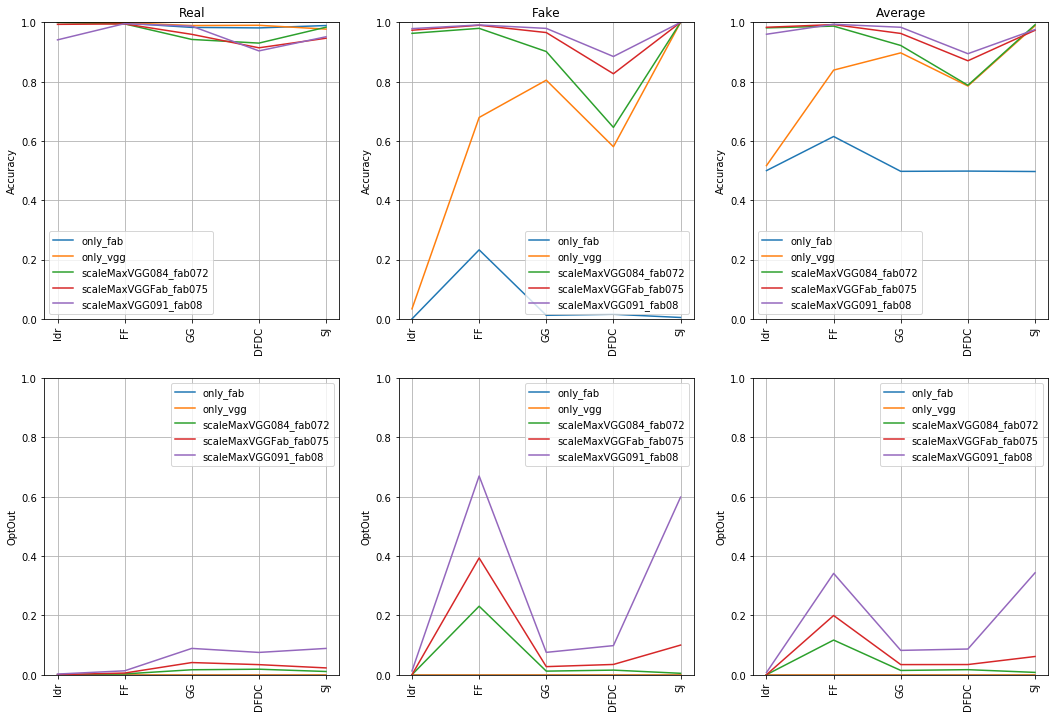

In [61]:
_, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))


plot_sim_acc(result_dfs, ['real'], 'only_fab', cur_thres=0.72, ax=ax[:, 0])
plot_sim_acc(result_dfs, ['fake'], 'only_fab', cur_thres=0.72, ax=ax[:, 1])
plot_sim_acc(result_dfs, ['real','fake'], 'only_fab', cur_thres=0.72, ax=ax[:, 2])

plot_sim_acc(result_dfs, ['real'], 'only_vgg', cur_thres=0.84, ax=ax[:, 0])
plot_sim_acc(result_dfs, ['fake'], 'only_vgg', cur_thres=0.84, ax=ax[:, 1])
plot_sim_acc(result_dfs, ['real','fake'], 'only_vgg', cur_thres=0.84, ax=ax[:, 2])

plot_sim_acc(result_dfs, ['real'], 'scaleMaxVGG084_fab072', cur_thres=0.0001, ax=ax[:, 0])
plot_sim_acc(result_dfs, ['fake'], 'scaleMaxVGG084_fab072', cur_thres=0.0001, ax=ax[:, 1])
plot_sim_acc(result_dfs, ['real','fake'], 'scaleMaxVGG084_fab072', cur_thres=0.0001, ax=ax[:, 2])

plot_sim_acc(result_dfs, ['real'], 'scaleMaxVGGFab_fab075', cur_thres=0.0001, ax=ax[:, 0])
plot_sim_acc(result_dfs, ['fake'], 'scaleMaxVGGFab_fab075', cur_thres=0.0001, ax=ax[:, 1])
plot_sim_acc(result_dfs, ['real','fake'], 'scaleMaxVGGFab_fab075', cur_thres=0.0001, ax=ax[:, 2])

plot_sim_acc(result_dfs, ['real'], 'scaleMaxVGG091_fab08', cur_thres=0.0001, ax=ax[:, 0])
plot_sim_acc(result_dfs, ['fake'], 'scaleMaxVGG091_fab08', cur_thres=0.0001, ax=ax[:, 1])
plot_sim_acc(result_dfs, ['real','fake'], 'scaleMaxVGG091_fab08', cur_thres=0.0001, ax=ax[:, 2])

ax[0, 0].set_title('Real')
ax[0, 1].set_title('Fake')
ax[0, 2].set_title('Average')
plt.show()